# PCA Statistical Arbitrage

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import scipy
import statsmodels.api as sm
import pandas as pd
from statsmodels.tsa.stattools import coint, grangercausalitytests
import matplotlib
from itertools import groupby, count
import pickle
import yfinance as yf
from dateutil.parser import parse
import datetime
from scipy.optimize import brentq 
import traceback
import quantstats as qs
%matplotlib inline

# Set Start Date

In [2]:
start_date = '2015-1-1'

# Build PCA from First Principles
First we download price data and compute the daily returns. Second we centre the data by substracting the mean. Third we compute the covariance matrix from the centred-returns data. Fourthly we then compute the eigenvalues and eigenvectors using the numpy linalg package.

In [3]:
stocks = yf.download('SPY,QQQ', start=start_date, end=None, auto_adjust=True).Close

[*********************100%***********************]  2 of 2 completed


In [4]:
stocks

Ticker,QQQ,SPY
Date,,
2015-01-02,95.016594,171.568008
2015-01-05,93.622803,168.469528
2015-01-06,92.367477,166.882751
2015-01-07,93.558167,168.962311
2015-01-08,95.348885,171.960571
...,...,...
2025-08-27,573.489990,646.630005
2025-08-28,577.080017,648.919983
2025-08-29,570.400024,645.049988


# Plot Prices

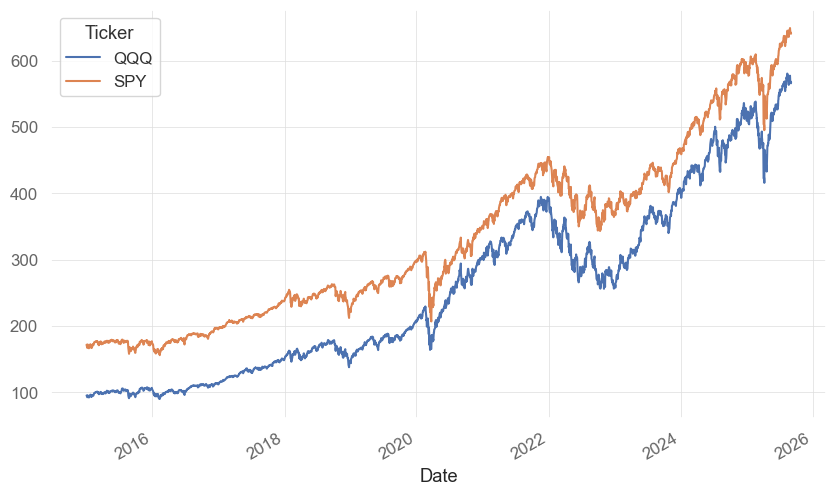

In [5]:
stocks.plot();

# Plot Log Returns

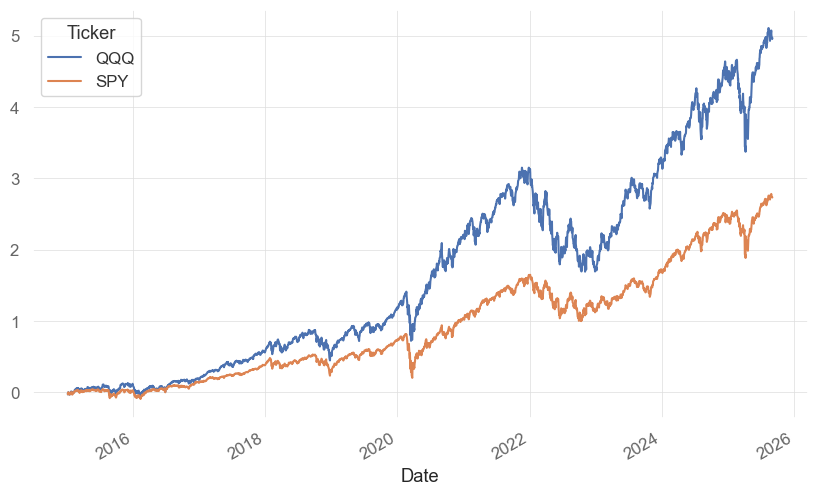

In [6]:
stocks.pct_change().add(1).cumprod().add(-1).plot();

# Step 1: Remove Mean from Time Series
Subtract the mean from the returns series to centre or de-mean the data

In [7]:
stocks_minus_mean = stocks.pct_change().dropna()-stocks.pct_change().mean()

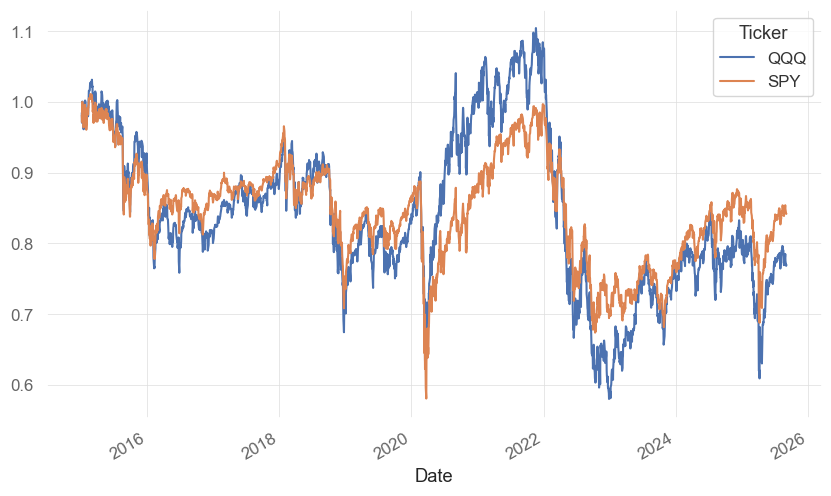

In [8]:
stocks_minus_mean.add(1).cumprod().plot();

# Step 2: Calculate the Coveriance
Calculate the covariance of the demeaned stock returns

In [9]:
S = stocks_minus_mean.cov()
S

Ticker,QQQ,SPY
Ticker,,
QQQ,0.000195,0.000147
SPY,0.000147,0.000128


# Step 3: Calculate the Eigenvalues & Eigenvectors
Calculate the Eigenvalues & Eigenvectors of the covariance matrix

In [10]:
EIG = np.linalg.eig(S)
EIG

(array([3.12166800e-04, 1.02304987e-05]),
 array([[ 0.78121294, -0.62426464],
        [ 0.62426464,  0.78121294]]))

## Eigenvalues:

In [11]:
print(EIG[0])

[3.12166800e-04 1.02304987e-05]


## Eigenvectors:

In [12]:
print(EIG[1])

[[ 0.78121294 -0.62426464]
 [ 0.62426464  0.78121294]]


Each eigenvector is one column of this matrix

We can see that the vectors are orthogonal to each other. This is also true for eigenvectors of higher dimensionality.

In [13]:
evect = EIG[1]

# Plot the Eigenvectors:

First, we create some x-values from the returns array

In [14]:
xvalues = np.linspace(np.nanmin(stocks_minus_mean.SPY),np.nanmax(stocks_minus_mean.SPY),200)

In [15]:
# Component 1
dx1 = evect[0,0]
dy1 = evect[1,0]
slope1 = dy1 / dx1

# Component 2
dx2 = evect[0,1]
dy2 = evect[1,1]
slope2 = dy2 / dx2

In [16]:
yvalues1 = slope1 * xvalues
yvalues2 = slope2 * xvalues

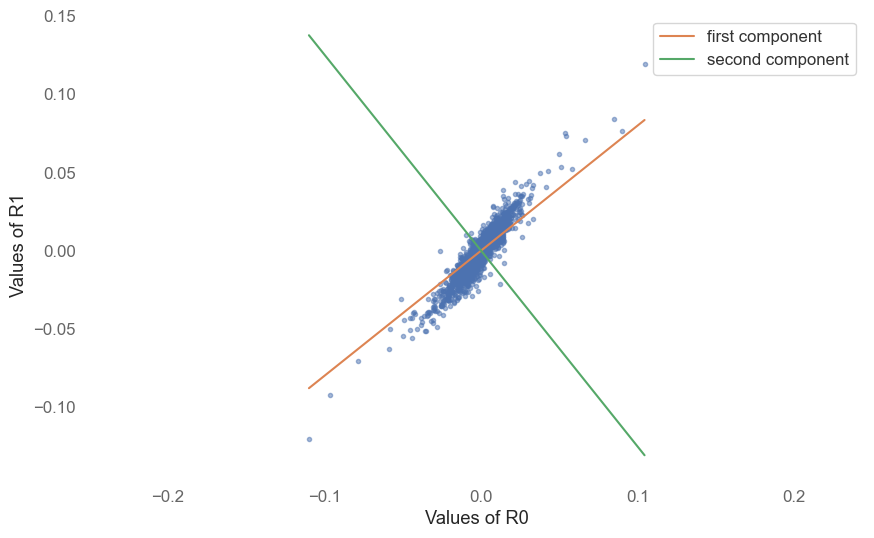

In [17]:
# Plot de-meaned x - y correlation
plt.plot(stocks_minus_mean.SPY, stocks_minus_mean.QQQ, '.', alpha=0.5)

# Plot the first principal component
plt.plot(xvalues, yvalues1, label='first component')

# Plot the second principal component
plt.plot(xvalues, yvalues2, label='second component')

plt.legend()
plt.xlabel('Values of R0')
plt.ylabel('Values of R1')
plt.grid()
plt.axis('equal');

# What is the difference between OLS and PCA:
OLS minimizies squared residuals parallel to the axis while PCA minimizes residuals orthogonal to eigenvectors.

Therefore, OLS does not give exactly the inverse slope if x and y axis are swapped while PCA does give the reverse slope exactly.

In [18]:
s1 = np.polyfit(stocks_minus_mean.SPY, stocks_minus_mean.QQQ, 1)[0]
s2 = np.polyfit(stocks_minus_mean.QQQ, stocks_minus_mean.SPY, 1)[0]
print(s1, 1/s2)

1.151312379017559 1.3208904533509145


# Compute PCA for an Asset Portfolio
Tech Stocks, Banking Stocks and Commodities

In [19]:
portfolio = yf.download('GOOG,AMZN,NFLX,BAC,JPM,WFC', start=start_date, end=None, auto_adjust=True).Close
commodty_pair = yf.download('RB=F,CL=F', start=start_date, end=None, auto_adjust=True).Close

[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed


# Ordered Eigenvectors by Significance
Here we build a PCA funtion that returns eigenvectors in order of their "significance" based on the size of the eigenvalues.
The PCA function follows the steps above i.e. subtract the mean, take the covariance then compute the eigenvalues and eigenvectors

In [20]:
def pca(stk):
  x = stk.pct_change().dropna()
  p = np.linalg.eig((x-x.mean()).cov())
  evals = p[0]
  evec = p[1]

  # Sorting the eigenvalues and eigenvectors
  return np.sort(evals/sum(evals))[::-1],evec[:,np.argsort(evals)[::-1]]

evals,evec = pca(portfolio)

# Explained Variance
This tells us how many principal components we need to explain x% of the variance in the data set.

Text(0, 0.5, 'explained variance')

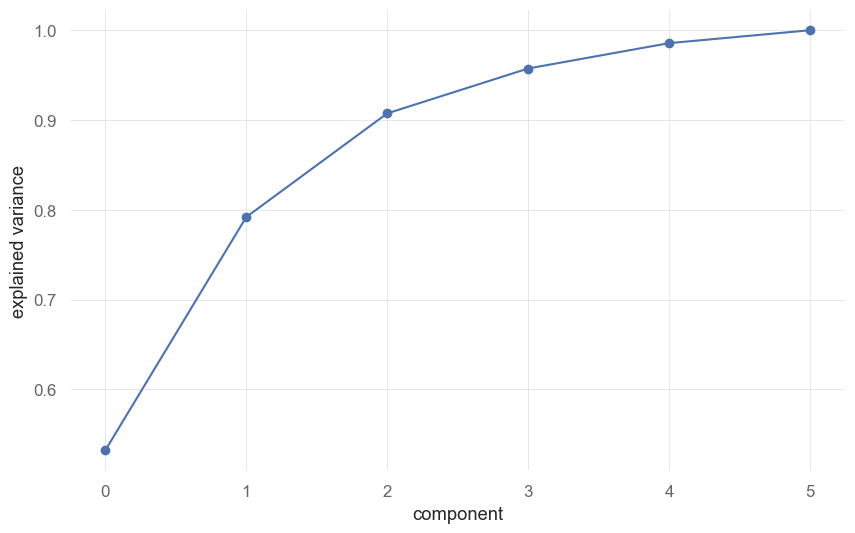

In [21]:
"""Explained Variance"""

plt.plot(np.cumsum(evals),'-o')
plt.xlabel('component')
plt.ylabel('explained variance')

# PCA Biplot - Find Hidden Factors / Clusters
We can use PCA to find "hidden" factors or clustering in the data.

Here we can see that by plotting the first two prinicpal components of the returns for different products

We can clearly distinguish between technology stocks (blue), banking stocks (green) and oil-based commodities (red).

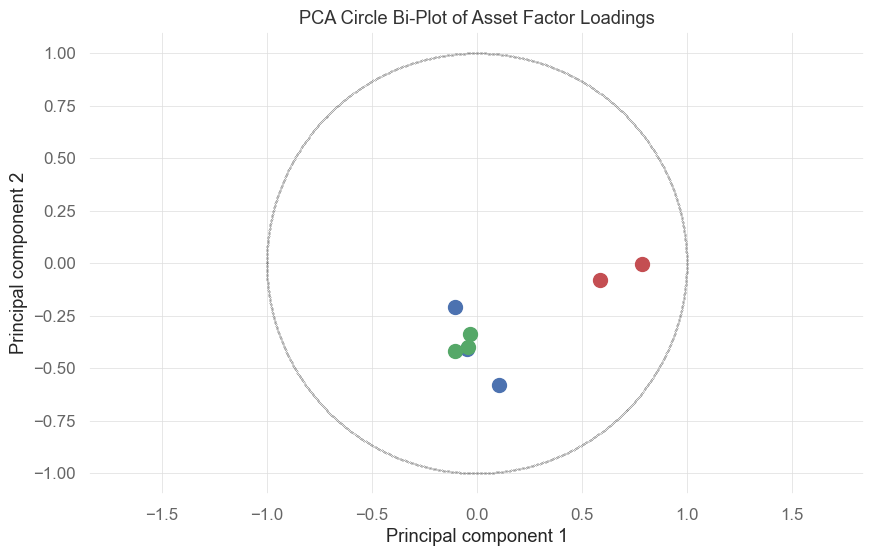

In [22]:
"""Factor Analysis"""
returns_list = []

# Set the rolling window length for return calculations
window = 100

# Commodities
returns_list.append(commodty_pair['CL=F'].pct_change().iloc[-window:].values)
returns_list.append(commodty_pair['RB=F'].pct_change().iloc[-window:].values)

# Tech Stocks
returns_list.append(portfolio['GOOG'].pct_change().iloc[-window:].values)
returns_list.append(portfolio['AMZN'].pct_change().iloc[-window:].values)
returns_list.append(portfolio['NFLX'].pct_change().iloc[-window:].values)

# Banking Stocks
returns_list.append(portfolio['JPM'].pct_change().iloc[-window:].values)
returns_list.append(portfolio['WFC'].pct_change().iloc[-window:].values)
returns_list.append(portfolio['BAC'].pct_change().iloc[-window:].values)

# Compute eigenvectors, use returns numpy array for covariance and eigenvector analytics
returns = np.array(returns_list)

returns_centered = returns - np.mean(returns);  # step 1 - Remove mean
covariance_matrix = np.cov(returns_centered);   # step 2 - Compute covariance matrix
eigenvectors = np.linalg.eig(covariance_matrix) # step 3 - Compute eigenvectors

# Set asset category colors for plot (commodities: red, tech: blue, banking: green)
asset_colors=['r']*2 + ['b']*3 + ['g']*3

# Project the original assets onto the first two principal components (for a 2D circle plot)
for asset_idx, eigenvector in enumerate(eigenvectors[1]):
    plt.plot(eigenvector[0], eigenvector[1], 'o', c=asset_colors[asset_idx], ms=10) # ms = marker size
    
# Add a unit circle to the plot to help visualize
angles = np.linspace(-np.pi, np.pi, 1000)
plt.plot(np.cos(angles), np.sin(angles), 'k.', ms=0.3)  # ms = marker size

plt.axis('equal')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('PCA Circle Bi-Plot of Asset Factor Loadings')
plt.show()

# Compare Asset Prices with PCA Implied Prices

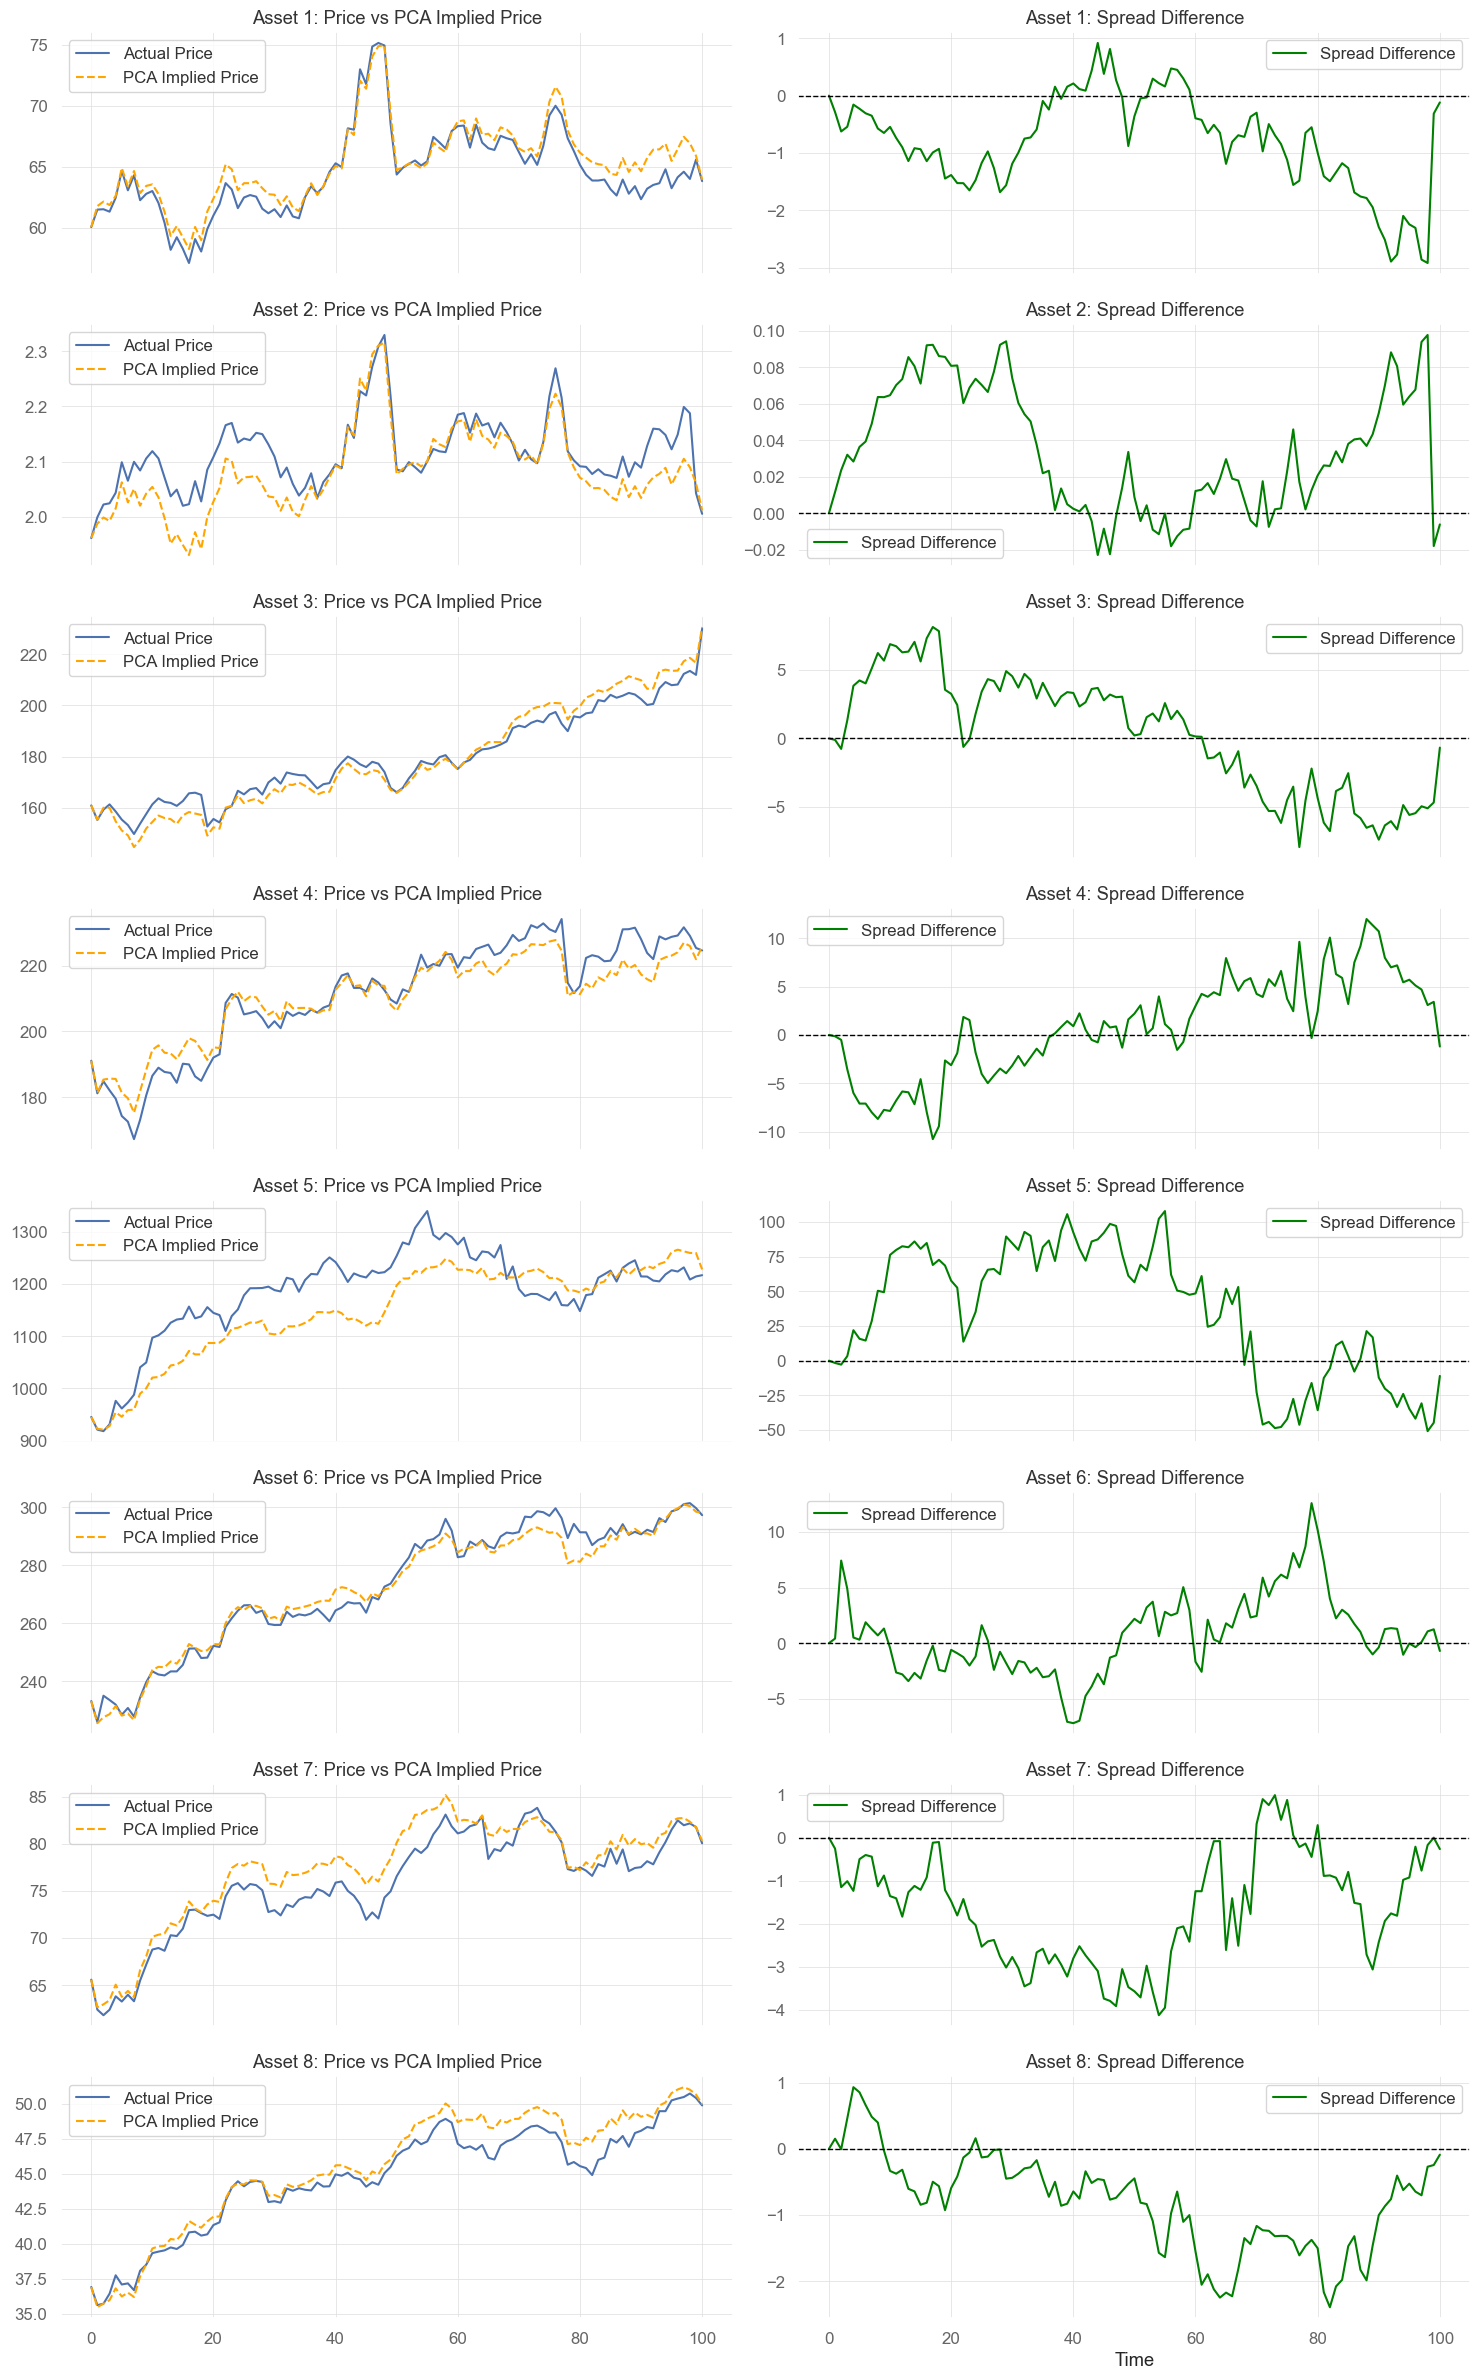

In [23]:
# prices_array shape (num_assets, window+1)
prices_array = np.array([
    commodty_pair['CL=F'].iloc[-(window+1):].values,
    commodty_pair['RB=F'].iloc[-(window+1):].values,
    portfolio['GOOG'].iloc[-(window+1):].values,
    portfolio['AMZN'].iloc[-(window+1):].values,
    portfolio['NFLX'].iloc[-(window+1):].values,
    portfolio['JPM'].iloc[-(window+1):].values,
    portfolio['WFC'].iloc[-(window+1):].values,
    portfolio['BAC'].iloc[-(window+1):].values,
])

# Max Principal Components = No. Assets
use_first_n_components = 3
principal_components = eigenvectors[1][:, :use_first_n_components]  # shape (num_assets, 3)

# Mean center returns **per asset** (axis=1), keepdims for broadcasting
returns_mean = np.mean(returns, axis=1, keepdims=True)
returns_centered = returns - returns_mean

# Transpose returns_centered for projection (window, assets)
returns_centered_T = returns_centered.T  # shape (window, num_assets)

# Project centered returns onto first 3 PCs (window, 3)
pc_scores = returns_centered_T @ principal_components

# Reconstruct returns approximation (window, num_assets)
returns_approx_centered = pc_scores @ principal_components.T

# Add back the per-asset mean returns correctly via broadcasting
returns_approx = returns_approx_centered + returns_mean.T  # returns_mean.T shape (1, num_assets)

# Reconstruct PCA implied prices by compounding returns starting from initial prices
pca_prices = np.zeros_like(prices_array)
pca_prices[:, 0] = prices_array[:, 0]

for t in range(1, prices_array.shape[1]):
    pca_prices[:, t] = pca_prices[:, t - 1] * (1 + returns_approx[t - 1, :])

# Calculate spread (actual - PCA implied price)
price_spread = prices_array - pca_prices

# Plot actual price and PCA implied price together in one chart + spread in separate plot
num_assets = prices_array.shape[0]
fig, axes = plt.subplots(num_assets, 2, figsize=(15, 3 * num_assets), sharex=True)

for i in range(num_assets):
    # Combined plot of actual price and PCA implied price
    axes[i, 0].plot(prices_array[i], label='Actual Price')
    axes[i, 0].plot(pca_prices[i], label='PCA Implied Price', color='orange', linestyle='--')
    axes[i, 0].set_title(f'Asset {i + 1}: Price vs PCA Implied Price')
    axes[i, 0].legend()

    # Spread difference plot
    axes[i, 1].plot(price_spread[i], label='Spread Difference', color='green')
    axes[i, 1].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[i, 1].set_title(f'Asset {i + 1}: Spread Difference')
    axes[i, 1].legend()

plt.xlabel('Time')
plt.tight_layout()
plt.show()

# How does PCA clustering information help when trading?
- **Identify stocks with similar behaviour** - 
Clusters correspond to similar price or return patterns driven by common factors (e.g., technology, banking, commodities).

- **Portfolio diversification** - 
By investing across distinct clusters, traders can reduce risk from sector concentration.

- Pairs or **statistical arbitrage candidates** selection - 
Stocks within the same cluster or close in PCA space may be more co-integrated or cointegrated, good pairs for mean-reversion strategies.

- **Factor-based risk models** - 
PCA-derived factors can be used as portfolio exposures or risk metrics.

- **Market regime detection** - 
Changes in cluster structure or PC loadings over time may signal market shifts or regime changes.

- **Dimensionality reduction** for predictive models - 
Using PCA components instead of raw data as features in machine learning models to improve signal-to-noise ratio.

## Cointegration

Adjusting for volatility, the RBOB gasoline vs Crude Oil pair seem to be highly cointegrated. Note: Cointegrated price series do not necessarily have to be correlated and vice-versa 
For more information please refer to Engle-Granger causality, see https://en.wikipedia.org/wiki/Granger_causality

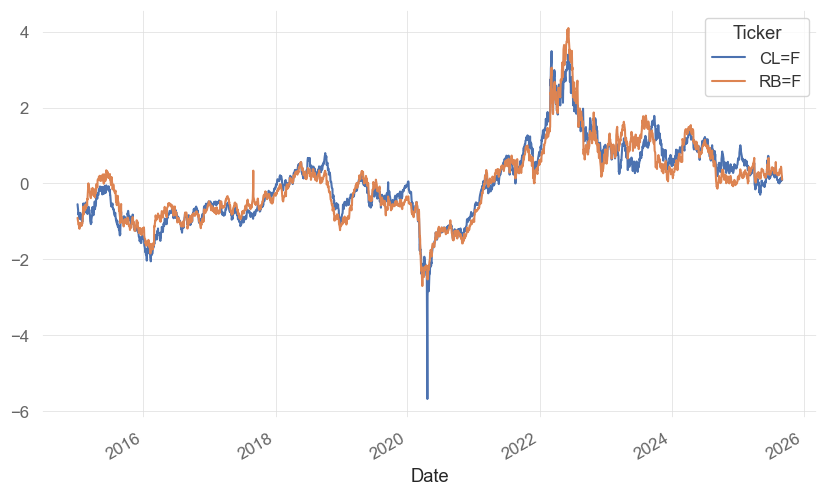

In [24]:
((commodty_pair-commodty_pair.mean())/commodty_pair.std()).plot();

# Engel-Granger Cointegration Test
Let's run the Granger cointegration test. The first component gives us the t-statisic, the second component is the p-value of the t-statistic and the the third component are the critical values of the t-statistic for the 99%, 95% and 90% confidence level.

(-5.480507052554448, 1.961008712632149e-05, array([-3.90052814, -3.33840914, -3.04603174]))


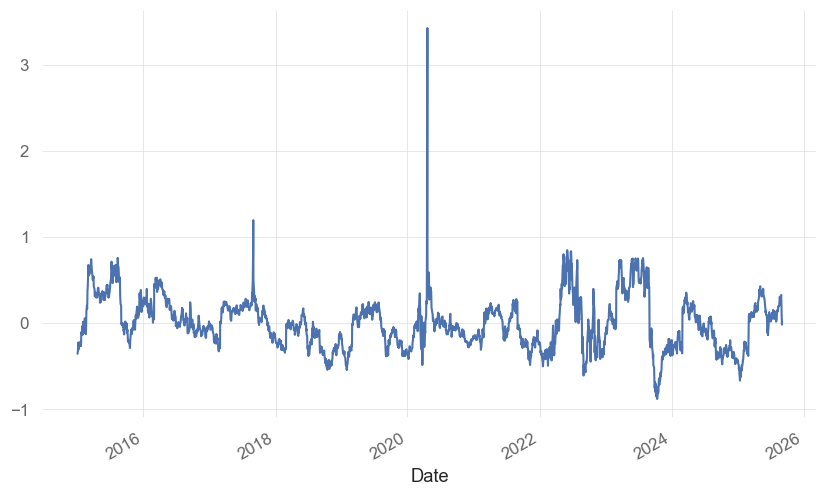

In [25]:
spread = ((commodty_pair-commodty_pair.mean())/commodty_pair.std()).dropna()
spread.diff(axis=1)['RB=F'].plot()
print(coint(spread['RB=F'],spread['CL=F']))

# Direction of Causality
The Engel-Granger causality test tells us the direction of causality in our data.

There are four directions of causality, 
- A leads B
- B leads A
- A or B may lead
- No-one leads

Here we can clearly see that price of Crude (CL) strongly leads the price of RBOB (RB) gasoline.

C:\Users\nburg\anaconda3\envs\epat39\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


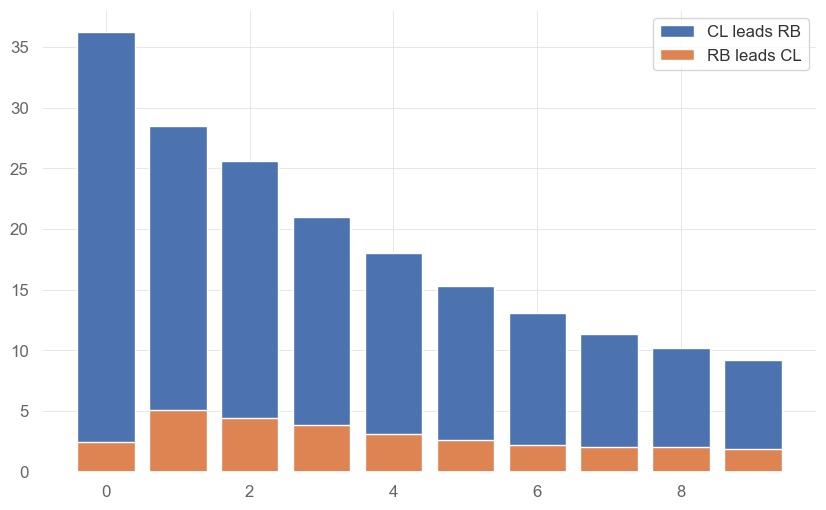

In [26]:
X = commodty_pair['CL=F'].ffill()
Y = commodty_pair['RB=F'].ffill()

lags = 10

# Calculating the EG-Test in one direction
result = grangercausalitytests(np.array([X,Y]).T, lags, verbose=False)

# Extracting results
res_fwd = [(list(result.values())[lag][0]['ssr_ftest'][0]) for lag in range(lags)]

# Calculating the EG-Test in reverse direction
result = grangercausalitytests(np.array([Y,X]).T, lags, verbose=False)

# Extracting results
res_rev = [(list(result.values())[lag][0]['ssr_ftest'][0]) for lag in range(lags)]

plt.bar(range(lags), res_fwd,label='CL leads RB')
plt.bar(range(lags), res_rev,label='RB leads CL')
plt.legend();

Now we can backtest the Crude/RBOB spread. Futures have a dollar value associated with each tick. In this simplified example, we assume the tick value is equal to the dollar value.

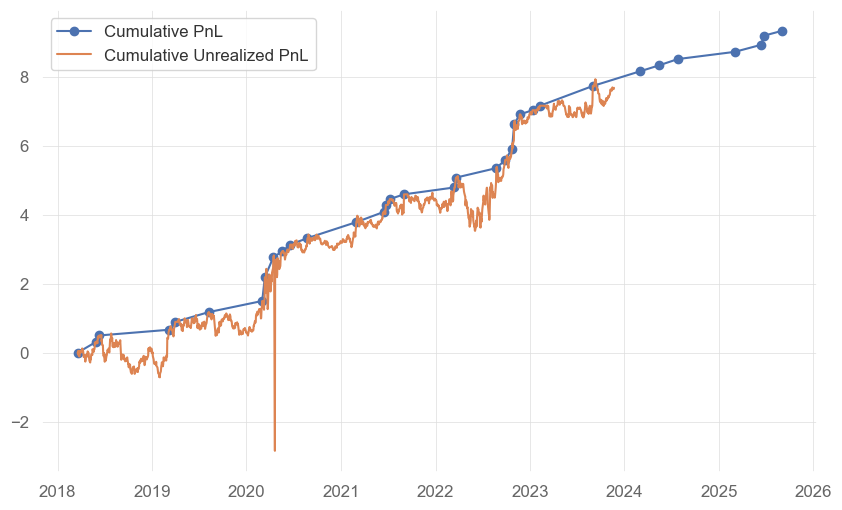

In [27]:
inpos = 0
pnls = [0]
unrlzd = []
dt = []

# Dynamic start index: could be 30%, 50%, or any logic you choose
start_idx = int(len(commodty_pair) * 0.3)

dates = [commodty_pair.index[start_idx]]
th = 0.1
comms = 0.0

for i in range(start_idx, len(commodty_pair)):
    if not inpos:
        pos = commodty_pair.iloc[:i].std()
        spread = ((commodty_pair - commodty_pair.iloc[:i].mean()).mul(1 / pos)).diff(axis=1).values[:, 1]

    # Unrealized PnL
    unrlzd.append((spread[i] - spread[i - 1]) * inpos)
    dt.append(commodty_pair.index[i])

    # Short entry
    if not inpos and spread[i] > th:
        inpos = -1
        entry = spread[i]

    # Short exit
    elif inpos < 0 and spread[i] < 0:
        unrlzd[-1] -= comms
        inpos = 0
        pnls.append(entry - spread[i])
        dates.append(commodty_pair.index[i])

    # Long entry
    elif not inpos and spread[i] < -th:
        inpos = 1
        entry = spread[i]

    # Long exit
    elif inpos > 0 and spread[i] > 0:
        unrlzd[-1] -= comms
        inpos = 0
        pnls.append(spread[i] - entry)
        dates.append(commodty_pair.index[i])

# Plot results
plt.plot(dates, np.cumsum(pnls), '-o', label='Cumulative PnL')
plt.plot(dt, np.cumsum(unrlzd), label='Cumulative Unrealized PnL')
plt.legend()
plt.show()


## Index arbitrage

We copy a list from the top S&P500 components from a website and extract the tickers:
https://topforeignstocks.com/indices/components-of-the-sp-500-index/

In [28]:
q="""Apple Inc.	AAPL	Information Technology
2	Microsoft Corporation	MSFT	Information Technology
3	Amazon.com Inc.	AMZN	Consumer Discretionary
4	Berkshire Hathaway Inc. Class B	BRK.B	Financials
5	Alphabet Inc. Class A	GOOGL	Communication Services
6	UnitedHealth Group Incorporated	UNH	Health Care
7	Alphabet Inc. Class C	GOOG	Communication Services
8	Johnson & Johnson	JNJ	Health Care
9	Exxon Mobil Corporation	XOM	Energy
10	JPMorgan Chase & Co.	JPM	Financials
11	NVIDIA Corporation	NVDA	Information Technology
12	Procter & Gamble Company	PG	Consumer Staples
13	Visa Inc. Class A	V	Information Technology
14	Home Depot Inc.	HD	Consumer Discretionary
15	Tesla Inc	TSLA	Consumer Discretionary
16	Chevron Corporation	CVX	Energy
17	Mastercard Incorporated Class A	MA	Information Technology
18	Eli Lilly and Company	LLY	Health Care
19	Pfizer Inc.	PFE	Health Care
20	AbbVie Inc.	ABBV	Health Care
21	Merck & Co. Inc.	MRK	Health Care
22	Meta Platforms Inc. Class A	META	Communication Services
23	PepsiCo Inc.	PEP	Consumer Staples
24	Coca-Cola Company	KO	Consumer Staples
25	Bank of America Corp	BAC	Financials
26	Broadcom Inc.	AVGO	Information Technology
27	Thermo Fisher Scientific Inc.	TMO	Health Care
28	Costco Wholesale Corporation	COST	Consumer Staples
29	Walmart Inc.	WMT	Consumer Staples
30	Cisco Systems Inc.	CSCO	Information Technology
31	McDonald's Corporation	MCD	Consumer Discretionary
32	Abbott Laboratories	ABT	Health Care
33	Danaher Corporation	DHR	Health Care
34	Accenture Plc Class A	ACN	Information Technology
35	NextEra Energy Inc.	NEE	Utilities
36	Verizon Communications Inc.	VZ	Communication Services
37	Linde plc	LIN	Materials
38	Walt Disney Company	DIS	Communication Services
39	Wells Fargo & Company	WFC	Financials
40	Adobe Incorporated	ADBE	Information Technology
41	Philip Morris International Inc.	PM	Consumer Staples
42	Bristol-Myers Squibb Company	BMY	Health Care
43	Comcast Corporation Class A	CMCSA	Communication Services"""

stk_list = []
for  string in q.split():
  if all(l.isupper() for l in string) and len(string)>2 and len(string)<5:
    stk_list.append(string)

## Download Price Data

In [29]:
np.random.shuffle(stk_list)
tickers = ",".join(stk_list)
top40 = yf.download(tickers, start=start_date, end=None, auto_adjust=True).Close.dropna()

[*********************100%***********************]  33 of 33 completed


Here we plot them:

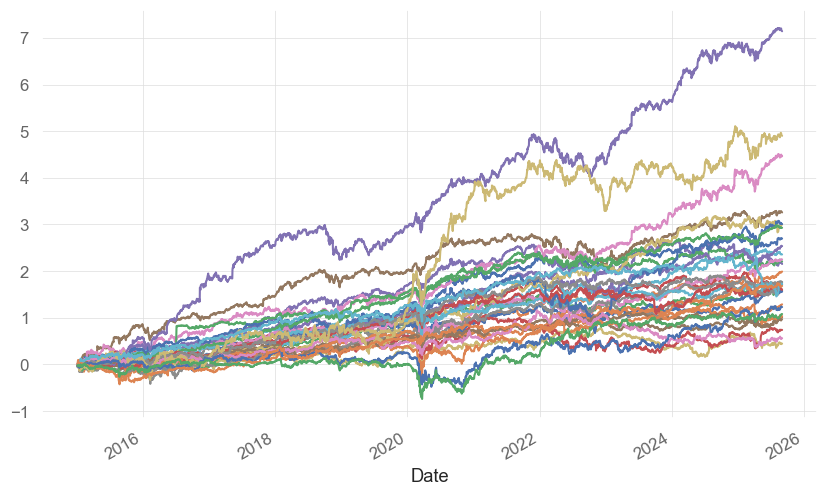

In [30]:
top40.pct_change().cumsum().plot(legend=False);

Next, we can create an eigen-porfolio using the first principal component as weights.

In [31]:
top40

Ticker,AAPL,ABBV,ABT,ACN,ADBE,AMZN,AVGO,BAC,BMY,COST,...,NEE,NVDA,PEP,PFE,TMO,TSLA,UNH,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,24.261049,42.394871,36.580612,74.252617,72.339996,15.426000,7.587783,14.356868,42.368382,114.297478,...,20.168501,0.483066,69.219109,19.017998,124.125458,14.620667,85.585030,40.370861,23.266562,58.423481
2015-01-05,23.577570,41.597046,36.588760,72.998917,71.980003,15.109500,7.466487,13.939797,41.706261,112.998047,...,19.954889,0.474907,68.698738,18.914806,122.420357,14.006000,84.175323,39.263798,23.198856,56.824890
2015-01-06,23.579796,41.391136,36.173252,72.472366,70.529999,14.764500,7.296673,13.522727,41.635071,114.491165,...,20.032404,0.460508,68.178329,19.072628,121.277138,14.085333,84.005470,38.444561,23.377623,56.522800
2015-01-07,23.910435,43.064034,36.466549,73.993515,71.110001,14.921000,7.493780,13.586897,42.176155,116.484802,...,20.215767,0.459308,70.171944,19.333649,124.910233,14.063333,84.863190,38.673355,23.997881,57.095528
2015-01-08,24.829128,43.514427,37.216099,75.121841,72.919998,15.023000,7.868279,13.867615,43.229832,117.485657,...,20.338634,0.476586,71.447266,19.728216,126.208473,14.041333,88.914017,39.529495,24.504379,58.045876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-26,229.309998,208.360001,131.589996,255.419998,354.910004,228.710007,298.010010,50.250000,47.209999,941.340027,...,74.265709,181.770004,147.000000,24.920000,488.480011,351.670013,300.429993,81.510002,96.050003,111.489998
2025-08-27,230.490005,208.059998,131.460007,257.119995,356.350006,229.119995,300.250000,50.380001,47.630001,949.520020,...,73.322998,181.600006,147.639999,25.070000,488.119995,349.600006,303.880005,82.500000,96.080002,112.750000
2025-08-28,232.559998,207.919998,131.369995,256.170013,353.959991,231.600006,308.649994,50.490002,46.880001,944.960022,...,72.089996,180.169998,146.979996,24.600000,489.739990,345.980011,302.290009,81.980003,96.110001,113.349998


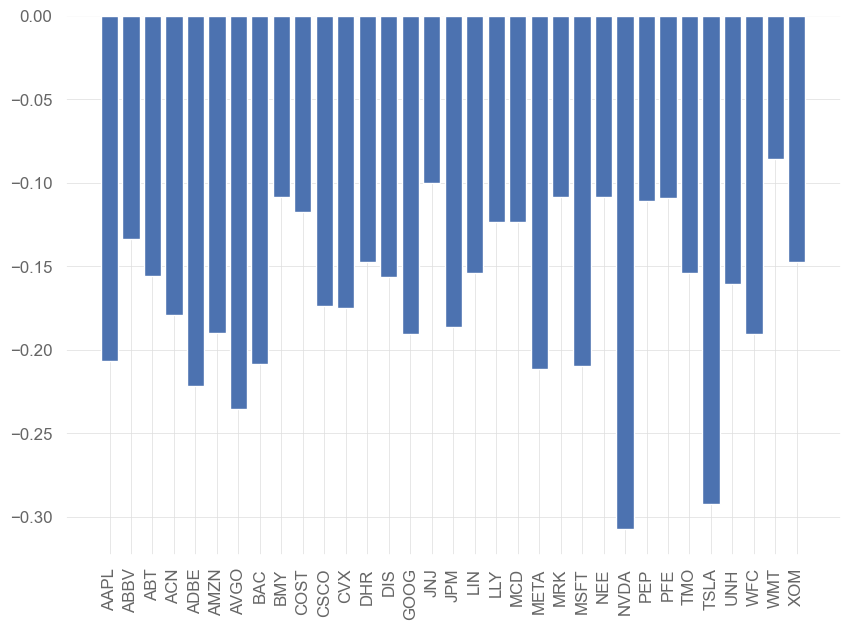

In [32]:
split = -800
evals,evec = pca(top40.iloc[:split])
eigportf = (top40.pct_change().mul(evec[:,0])).sum(axis=1).cumsum()
index = stocks.loc[eigportf.index[0]:].SPY.pct_change().cumsum().ffill()

plt.figure(figsize=[10,7])
plt.bar(top40.columns,evec[:,0])
plt.xticks(rotation=90);

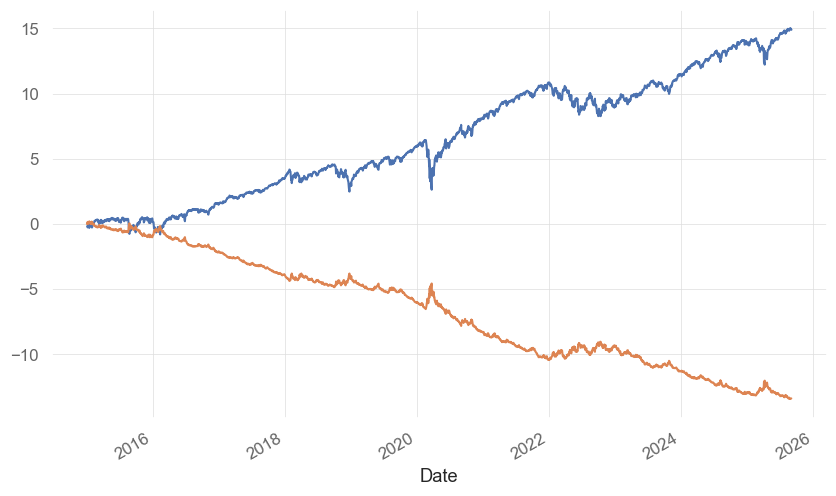

In [33]:
index.mul(10).plot()
eigportf.mul(1).plot();

## Correlation
We can see that there is a strong correlation between our eigenporfolio and the SPY ETF.

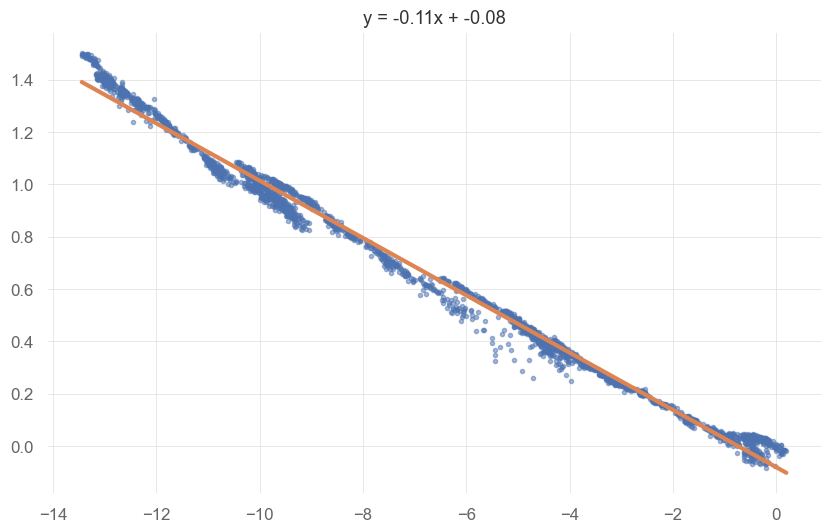

In [34]:
common_index = eigportf.index.intersection(index.index)
eigportf_aligned = eigportf.loc[common_index].dropna()
index_aligned = index.loc[common_index].dropna()

# Explicitly get minimum length after dropna
n = min(len(eigportf_aligned), len(index_aligned))

x = eigportf_aligned.iloc[:n].values
y = index_aligned.iloc[:n].values

plt.plot(x, y, '.', alpha=0.5)
m = np.polyfit(x, y, 1)
xx = np.linspace(x.min(), x.max(), 100)
yy = np.polyval(m, xx)
plt.plot(xx, yy, lw=3)
plt.title(f'y = {m[0]:.2f}x + {m[1]:.2f}')
plt.show()

## Mean Reversion
The portfolio also looks strongly mean reverting.

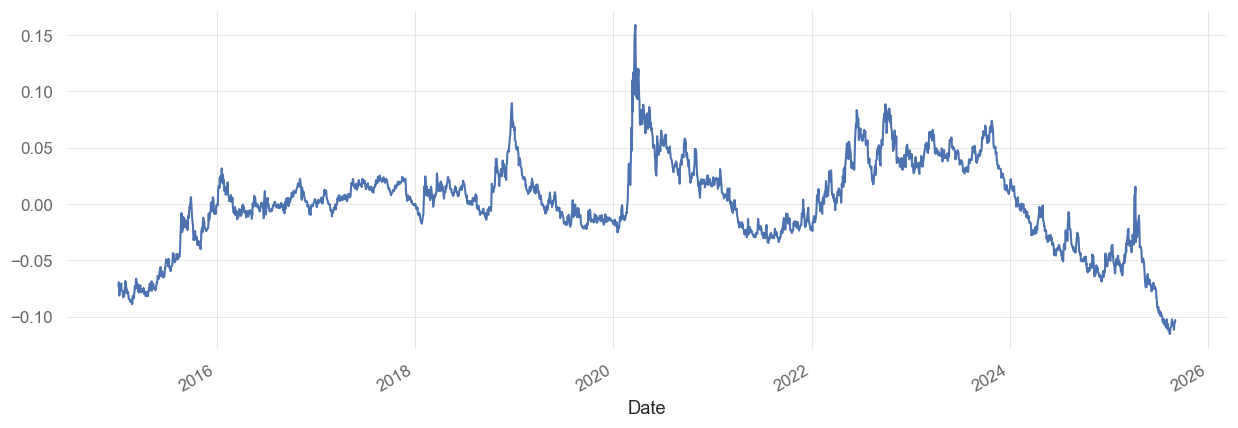

In [35]:
(eigportf*m[0]+m[1]-index).plot(figsize=[15,5]);

## Conintegration Check
Check if cointegrated at the 95% confidence level

In [36]:
# Ensure fit coefficients variable (e.g. m) is properly named identical
linear_comb = eigportf_aligned * m[0] + m[1]

# Slice both to minimum length to avoid mismatch (usually lengths match after alignment)
n = min(len(linear_comb), len(index_aligned))

# tuple: (test_statistic, p_value, critical_values)
coint(linear_comb.iloc[:n], index_aligned.iloc[:n])

(-2.4973019952601265,
 0.2802602215063106,
 array([-3.9005312 , -3.33841084, -3.04603292]))

## Statistical Arbitrage Trading Strategy Using PCA Residuals
This trading strategy exploits mean-reverting behavior in the residual spread between an index and its PCA-based replication portfolio. By entering long or short positions when residuals deviate beyond a dynamically scaled threshold and closing those positions upon mean reversion, it aims to capture profits from statistical mispricings in the market.

In [37]:
# Calculate residual series as difference between PCA portfolio estimate and actual index
regression_coeffs = m
residuals = eigportf * regression_coeffs[0] + regression_coeffs[1] - index

position = 0                      # Current position: 0 = no position, 1 = long, -1 = short
bandwidth = 0.1                   # Threshold for entering trades, scaled by residual std dev
unrealized_pnls = []              # List of unrealized PnLs during open positions
unrealized_dates = []             # Dates corresponding to unrealized PnLs
realized_pnls = []                # List of realized profit & losses
trade_entry_dates = []            # Dates when trades are entered (closed positions are recorded here)
min_history = 100                 # Minimum historical points before starting trading

for idx, residual_val in enumerate(residuals):
    if idx > min_history:  # Wait for enough data to estimate spread std dev

        # Calculate unrealized PnL as change in residual times current position
        if idx > 0:
            unrealized_pnls.append((residual_val - residuals.iloc[idx - 1]) * position)
            unrealized_dates.append(residuals.index[idx])

        # Entry: Long when residual drops below negative threshold (scaled std dev band)
        if position == 0 and residual_val < residuals.iloc[:idx].std() * (-bandwidth):
            entry_price = residual_val
            position = 1

        # Exit: Close long when residual crosses back above zero
        elif position == 1 and residual_val > 0:
            pnl = residual_val - entry_price
            realized_pnls.append(pnl)
            trade_entry_dates.append(residuals.index[idx])
            position = 0

        # Entry: Short when residual rises above positive threshold (scaled std dev band)
        elif position == 0 and residual_val > residuals.iloc[:idx].std() * bandwidth:
            entry_price = residual_val
            position = -1

        # Exit: Close short when residual crosses back below zero
        elif position == -1 and residual_val < 0:
            pnl = entry_price - residual_val
            realized_pnls.append(pnl)
            trade_entry_dates.append(residuals.index[idx])
            position = 0


## Plot the Results

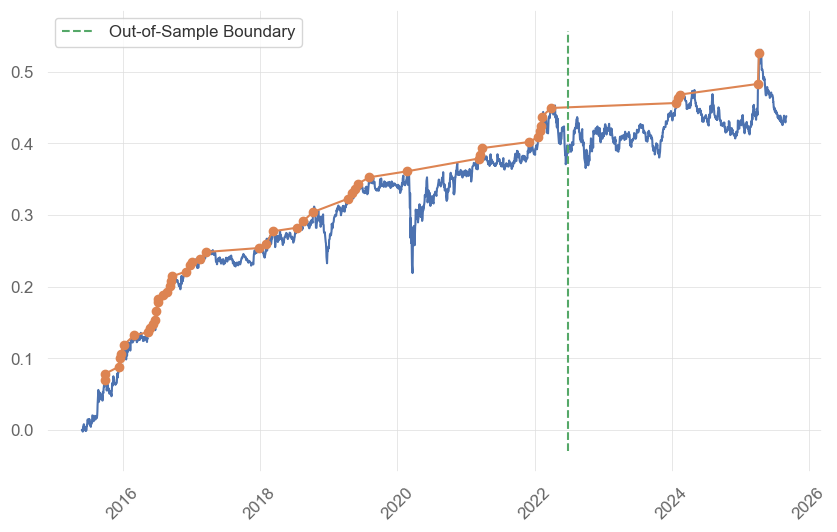

In [38]:
plt.plot(unrealized_dates,np.cumsum(unrealized_pnls),'-')
plt.plot(trade_entry_dates,np.cumsum(realized_pnls),'-o')
plt.xticks(rotation=45)

xmin,xmax,ymin,ymax = plt.axis()

plt.plot([residuals.index[split]]*2, [ymin,ymax], '--', label='Out-of-Sample Boundary')
plt.legend();